<a href="https://colab.research.google.com/github/aiml-aa/ML_Models/blob/main/Person_Place_Animal_Thing_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import pandas as pd

## Import the data csv file you made

import data

In [2]:
DATADIR = './data/'

if not os.path.exists(DATADIR):
    os.makedirs(DATADIR)

In [4]:
FULL_DATASET_NAME = 'terms_samples.csv'
FULL_DATASET_PATH = os.path.join(DATADIR, FULL_DATASET_NAME)

# Read the CSV file
data = pd.read_csv('Planning_ML Models_Projects_Model_1_thing.csv')

# Shuffle the data
shuffled_data = data.sample(n=len(data))

# Save the data
shuffled_data.to_csv(
    FULL_DATASET_PATH, header=False, index=False, encoding='utf-8')


In [5]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import (
    Embedding,
    Flatten,
    GRU,
    Conv1D,
    Lambda,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

2.12.0


In [6]:
%matplotlib inline

Let's start by specifying where the information about the trained models will be saved as well as where our dataset is located:

In [7]:
LOGDIR = "./text_models"
DATA_DIR = "./data"

## Loading the dataset

Our dataset consists of titles of articles along with the label indicating from which source these articles have been taken from (GitHub, Tech-Crunch, or the New-York Times).

In [8]:
DATASET_NAME = "terms_samples.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ['term', 'categories']

terms_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
terms_df.head()

,term,categories
0,Lakeshia Terminesi,person
1,Corgipoo,animal
2,Gracie Sambora,person
3,Diaper,thing
4,North American Black Bear,animal


## Integerize the texts

The first thing we need to do is to find how many words we have in our dataset (`VOCAB_SIZE`), how many titles we have (`DATASET_SIZE`), and what the maximum length of the titles we have (`MAX_LEN`) is. Keras offers the `Tokenizer` class in its `keras.preprocessing.text` module to help us with that:

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(terms_df.term)

In [10]:
integerized_terms = tokenizer.texts_to_sequences(terms_df.term)
integerized_terms[:3]

[[694, 1593], [1594], [1595, 1596]]

In [11]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

12120

In [12]:
DATASET_SIZE = tokenizer.document_count
DATASET_SIZE

10686

In [13]:
MAX_LEN = max(len(sequence) for sequence in integerized_terms)
MAX_LEN

5

Let's now implement a function `create_sequence` that will 
* take as input our titles as well as the maximum sentence length and 
* returns a list of the integers corresponding to our tokens padded to the sentence maximum length

Keras has the helper functions `pad_sequence` for that on the top of the tokenizer methods.

In [14]:
# TODO 1
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, max_len, padding='post')
    return padded_sequences

In [15]:
sequences = create_sequences(terms_df.term[:3])
sequences

array([[ 694, 1593,    0,    0,    0],
       [1594,    0,    0,    0,    0],
       [1595, 1596,    0,    0,    0]], dtype=int32)

In [17]:
terms_df.categories[:4]

0    person
1    animal
2    person
3     thing
Name: categories, dtype: object

We now need to write a function that 
* takes a title source and
* returns the corresponding one-hot encoded vector

Keras `to_categorical` is handy for that.

In [18]:
CLASSES = {
    'person': 0,
    'place': 1,
    'animal': 2,
    'thing': 3
}
N_CLASSES = len(CLASSES)

In [19]:
# TODO 2
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [21]:
encode_labels(terms_df.categories[:4])

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

## Preparing the train/test splits

Let's split our data into train and test splits:

In [22]:
N_TRAIN = int(DATASET_SIZE * 0.80)

terms_train, categories_train = (
    terms_df.term[:N_TRAIN], terms_df.categories[:N_TRAIN])

terms_valid, categories_valid = (
    terms_df.term[N_TRAIN:], terms_df.categories[N_TRAIN:])

To be on the safe side, we verify that the train and test splits
have roughly the same number of examples per classes.

Since it is the case, accuracy will be a good metric to use to measure
the performance of our models.


In [23]:
categories_train.value_counts()

thing     2355
animal    2242
person    2217
place     1734
Name: categories, dtype: int64

In [24]:
categories_valid.value_counts()

thing     590
person    571
animal    546
place     431
Name: categories, dtype: int64

Using `create_sequence` and `encode_labels`, we can now prepare the
training and validation data to feed our models.

The features will be
padded list of integers and the labels will be one-hot-encoded 3D vectors.

In [25]:
X_train, Y_train = create_sequences(terms_train), encode_labels(categories_train)
X_valid, Y_valid = create_sequences(terms_valid), encode_labels(categories_valid)

In [26]:
X_train[:3]

array([[ 694, 1593,    0,    0,    0],
       [1594,    0,    0,    0,    0],
       [1595, 1596,    0,    0,    0]], dtype=int32)

In [27]:
Y_train[:3]

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

## Building a DNN model

The build_dnn_model function below returns a compiled Keras model that implements a simple embedding layer transforming the word integers into dense vectors, followed by a Dense softmax layer that returns the probabilities for each class.


Note that we need to put a custom Keras Lambda layer in between the Embedding layer and the Dense softmax layer to do an average of the word vectors returned by the embedding layer. This is the average that's fed to the dense softmax layer. By doing so, we create a model that is simple but that loses information about the word order, creating a model that sees sentences as "bag-of-words".

In [28]:
def build_dnn_model(embed_dim):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]), # TODO 3
        Lambda(lambda x: tf.reduce_mean(x, axis=1)), # TODO 4
        Dense(N_CLASSES, activation='softmax') # TODO 5
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Below we train the model on 100 epochs but adding an `EarlyStopping` callback that will stop the training as soon as the validation loss has not improved after a number of steps specified by `PATIENCE` . Note that we also give the `model.fit` method a Tensorboard callback so that we can later compare all the models using TensorBoard.

Epoch 1/100
29/29 [==============================] - 1s 15ms/step - loss: 1.3823 - accuracy: 0.3012 - val_loss: 1.3780 - val_accuracy: 0.3162
Epoch 2/100
29/29 [==============================] - 0s 7ms/step - loss: 1.3703 - accuracy: 0.3156 - val_loss: 1.3701 - val_accuracy: 0.3120
Epoch 3/100
29/29 [==============================] - 0s 8ms/step - loss: 1.3580 - accuracy: 0.3287 - val_loss: 1.3623 - val_accuracy: 0.3232
Epoch 4/100
29/29 [==============================] - 0s 8ms/step - loss: 1.3442 - accuracy: 0.3528 - val_loss: 1.3538 - val_accuracy: 0.3471
Epoch 5/100
29/29 [==============================] - 0s 7ms/step - loss: 1.3282 - accuracy: 0.4002 - val_loss: 1.3444 - val_accuracy: 0.3840
Epoch 6/100
29/29 [==============================] - 0s 7ms/step - loss: 1.3098 - accuracy: 0.4381 - val_loss: 1.3340 - val_accuracy: 0.4036
Epoch 7/100
29/29 [==============================] - 0s 8ms/step - loss: 1.2891 - accuracy: 0.4545 - val_loss: 1.3226 - val_accuracy: 0.4177
Epoch 8/100


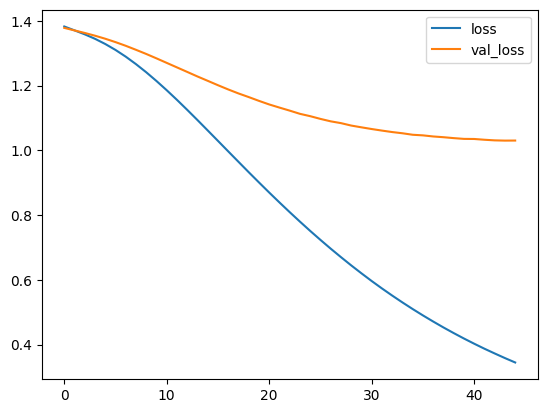

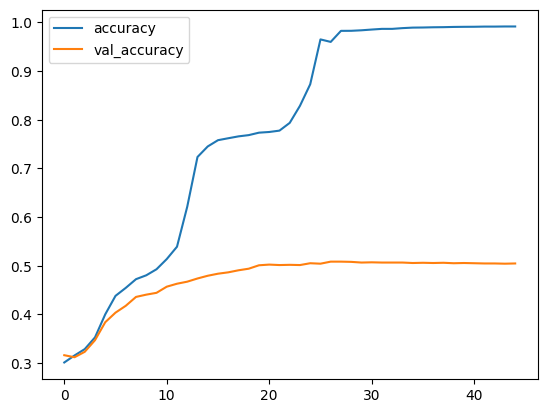

In [29]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

Next we need to save the model and test it

In [30]:
dnn_model.save('Arj_Thing_Model_1.h5')

In [31]:
import keras

In [32]:

# Load the saved model
loaded_model = keras.models.load_model('Arj_Thing_Model_1.h5')



In [37]:
Arj_test_1 = create_sequences(["Taylor Swift", "Selena Gomez", "Ryan Giggs", "bobcat", "rat", "clock", "New York"])


In [38]:
# Use the loaded model for prediction
predictions = loaded_model.predict(Arj_test_1)

1/1 [==============================] - 0s 27ms/step


In [39]:
print(predictions)

[[0.67377174 0.05893223 0.12603009 0.14126593]
 [0.36739177 0.14439593 0.1723717  0.3158405 ]
 [0.12645058 0.29917586 0.15793228 0.41644126]
 [0.12844868 0.2503031  0.46262312 0.1586251 ]
 [0.08634794 0.1926639  0.6197177  0.10127044]
 [0.05235775 0.11887413 0.04492586 0.78384227]
 [0.01048919 0.84579736 0.04453935 0.09917404]]
